<a target="_blank" href="https://colab.research.google.com/github/themis-ai/capsa/blob/main/notebooks/5_High-Dimensional-Depth.ipynb">
<img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

# High Level Introduction to `Capsa` with a Real World Problem

There are two axes of neural network uncertainty that can be modeled: 
- uncertainty in the data, called aleatoric uncertainty. This could be for example sensor noise or motion noise, resulting in uncertainty which cannot be reduced even if more data were to be collected. 
- uncertainty in the prediction, called epistemic uncertainty. It can be explained away given enough data, and is often referred to as model uncertainty.

In this notebook we will train models which can predict both types of uncertainty. We will see that model exhibits
- increased aleatoric uncertainty on object boundaries and for objects far from the camera
- increased epistemic uncertainty for semantically and visually challenging pixels.

However modeling only one of them comes at a cost. Out-of-distribution examples, which can be identified with epistemic uncertainty, cannot be identified with aleatoric uncertainty alone and vice versa. Thus we will combine both of the uncertainties to leverage their strength. 

In [ ]:
!pip install capsa

# download helper functions for this tutorial
!git clone --depth 1 https://github.com/themis-ai/capsa.git
%cd /content/capsa/notebooks/utils/depth

# download and extract dataset
!wget -q http://argo-1.themisai.io/demos/nyu_depth/nyu.h5

In [2]:
import tensorflow as tf
import config as config

In [3]:
from utils import get_datasets
ds_train, ds_test = get_datasets(
    id_path = "nyu.h5",
)

In this tutorial we will demonstrate how capsa can be used as a large-scale risk and uncertainty benchmarking framework for existing methods in the community. To that end, we will train a U-Net style model on the task of monocular end-to-end depth estimation using the "NYU Depth V2" dataset (RGB-to-depth image pairs of indoor scenes). 
Specifically, model's final layer outputs a single H × W activation map.

### Base model

First, we initialize a base model and visualize its prediction. A "base model" could be any keras Sequential or Functional model for any arbitrary task.

We will use a [U-Net](https://arxiv.org/abs/1505.04597) style model for our task. On a high level through its contracting path (left side) the model is able to capture the global context information, however for the pixel level tasks (e.g. semantic segmentation, depth estimation) granular local information is also required, therefore in the expansive path (right side) the architecture combines the upsampled global representation with the local context from the corresponding earlier layers. This allows the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture.

<img src="assets/unet_architecture.png" width="800" height="400">

In [4]:
from models import unet
base_model = unet(compile=True)

Let's visualize predictions of the model.

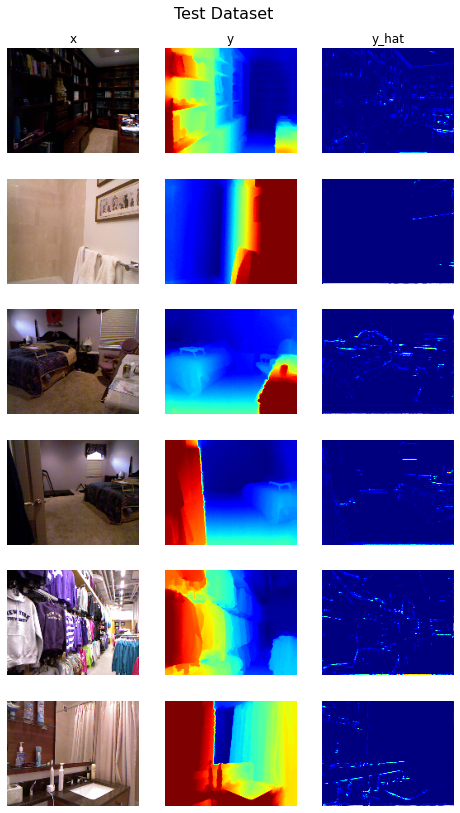

In [5]:
from utils import vis_depth_map
vis_depth_map(base_model, ds_test, plot_risk=False)

As expected, the model outputs random predictions... It's time to train it!

In [6]:
history = base_model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20
256/256 [==============================] - 19s 69ms/step - loss: 0.0709 - val_loss: 0.0442
Epoch 2/20
256/256 [==============================] - 17s 68ms/step - loss: 0.0343 - val_loss: 0.0262
Epoch 3/20
256/256 [==============================] - 18s 68ms/step - loss: 0.0203 - val_loss: 0.0157
Epoch 4/20
256/256 [==============================] - 18s 69ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 5/20
256/256 [==============================] - 18s 69ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 6/20
256/256 [==============================] - 18s 70ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 7/20
256/256 [==============================] - 18s 70ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 8/20
256/256 [==============================] - 18s 70ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
256/256 [==============================] - 18s 70ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/20
256/256 [==============================] - 18s 70ms/step - loss: 0.002

Let's visualize predictions of the trained model.

We see that the model produces reasonable predictions on the train and test datasets, however by default the model does not provide a risk estimate. We see that on the out of distribution dataset model's performance is close to random, but the model cannot distinguish such out of distribution scenarios. In other words, the model cannot estimate when it's predictions are not to be trusted therefore using such a model in production for any real world problem (and especially for time and safety critical applications) could lead to disastrous results.

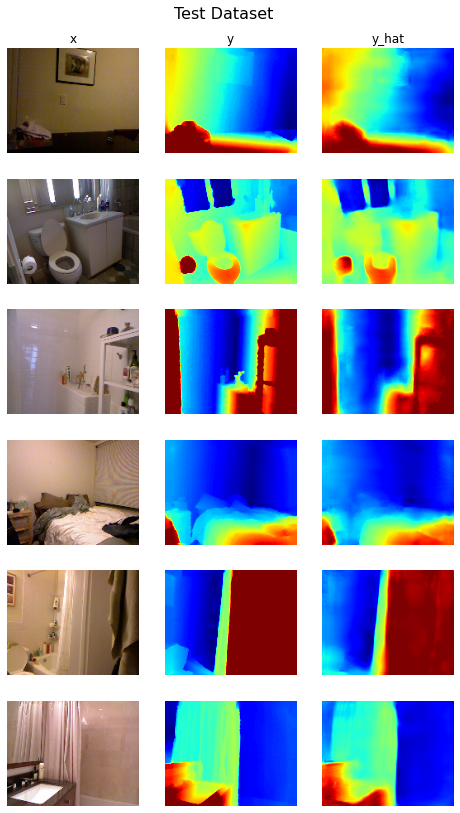

In [7]:
vis_depth_map(base_model, ds_test, plot_risk=False)

## Capsa

Existing algorithms to achieve risk-awareness of NNs are complex and ad-hoc. Specifically, these methods require significant engineering changes, are often developed only for particular settings, and are not easily
composable.

We present Capsa -- a model agnostic framework for risk estimation. Which allows for seamless and efficient integration of the uncertainty estimates to the existing models in a couple
lines of code.

Wrappers transform a model into a risk-aware variant. They are given an arbitrary neural network and, while preserving the structure and function of the network, add and modify the relevant components of the model in order to be a drop-in replacement while being able to estimate the risk metric.

Capsa [implements](https://themisai.io/capsa/api_documentation/index.html#) multiple different wrappers which allow us to capture different forms of risk. 

Let's see it in practice and wrap our "base model" ...

### 1. Aleatoric Wrapper
Allows to capture uncertainty in the data. This could be for example sensor noise or motion noise, resulting in uncertainty which cannot be reduced even if more data were to be collected. Detailed documentation could be found [here](https://themisai.io/capsa/api_documentation/MVEWrapper.html).

To leverage the functionality provided by Capsa, user could simply wrap their model with one of our wrappers.
Importantly, capsa works “out of the box” without requiring any modifications since it is a highly configurable, model-agnostic framework with modularity as one of the core of its design principles.

In [8]:
from capsa import MVEWrapper
user_model = unet()
aleatoric_model = MVEWrapper(user_model)
aleatoric_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LR),
    loss="mse",
)

Now, let's train a risk aware model! Note, it doesn't take any additional steps.

In [9]:
history = aleatoric_model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20
256/256 [==============================] - 20s 74ms/step - mve_compiled_loss: 0.1167 - mve_wrapper_loss: -1.6244 - val_mve_compiled_loss: 0.0492 - val_mve_wrapper_loss: -1.8938
Epoch 2/20
256/256 [==============================] - 19s 73ms/step - mve_compiled_loss: 0.0475 - mve_wrapper_loss: -2.0799 - val_mve_compiled_loss: 0.0381 - val_mve_wrapper_loss: -1.9391
Epoch 3/20
256/256 [==============================] - 19s 73ms/step - mve_compiled_loss: 0.0365 - mve_wrapper_loss: -2.4177 - val_mve_compiled_loss: 0.0381 - val_mve_wrapper_loss: -2.2012
Epoch 4/20
256/256 [==============================] - 19s 73ms/step - mve_compiled_loss: 0.0241 - mve_wrapper_loss: -2.9760 - val_mve_compiled_loss: 0.0208 - val_mve_wrapper_loss: -2.0158
Epoch 5/20
256/256 [==============================] - 19s 73ms/step - mve_compiled_loss: 0.0187 - mve_wrapper_loss: -3.2135 - val_mve_compiled_loss: 0.0112 - val_mve_wrapper_loss: -3.9911
Epoch 6/20
256/256 [==============================] - 19s 73

Now we see that in addition to y_hat (as the base model above) our risk aware model also produces a risk estimate (we plot is as the rightmost column), this measurement reflects model's uncertainty. We see that when we wrap the model with an aleatoric method we can successfully detect label noise or mislabeled data – the model exhibits increased aleatoric uncertainty on object boundaries, and indeed we see that the ground truth has noisy labels particularly on the edges of these objects; this could be due to sensor noise or motion noise.

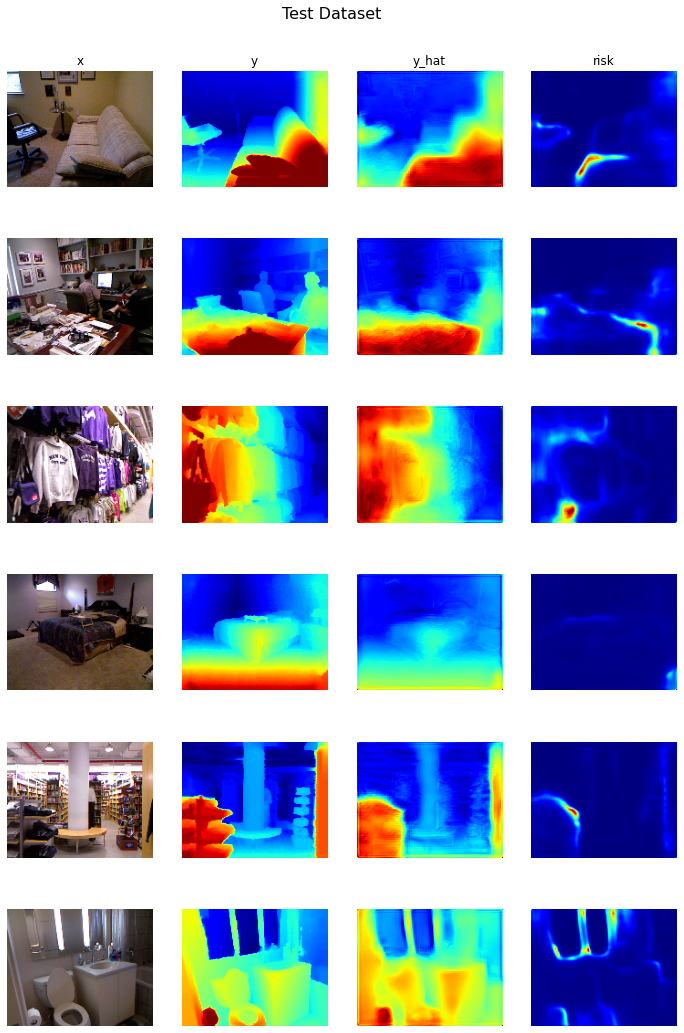

In [10]:
vis_depth_map(aleatoric_model, ds_test)

Let's try out another Capsa's wrapper, which measures a different type of risk.

### 2. Epistemic Wrapper

This wrapper allows to capture uncertainty in the model prediction. As opposed to the risk estimate we saw earlier, epistemic uncertainty can be explained away given enough data / or a more expressive model, and is often referred to as model uncertainty. Detailed documentation could be found here: [DropoutWrapper](https://themisai.io/capsa/api_documentation/DropoutWrapper.html), [VAEWrapper](https://themisai.io/capsa/api_documentation/VAEWrapper.html), [EnsembleWrapper](https://themisai.io/capsa/api_documentation/EnsembleWrapper.html).

Same as with any other Capsa wrapper, user could simply wrap their model with it.

In [11]:
from capsa import EnsembleWrapper
user_model = unet()
epistemic_model = EnsembleWrapper(user_model, num_members=3)
epistemic_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LR),
    loss="mse",
)

In [12]:
history = epistemic_model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20
256/256 [==============================] - 55s 206ms/step - usermodel_0_compiled_loss: 0.0842 - usermodel_1_compiled_loss: 0.1010 - usermodel_2_compiled_loss: 0.1916 - average_loss: 0.1256 - val_usermodel_0_compiled_loss: 0.0557 - val_usermodel_1_compiled_loss: 0.0615 - val_usermodel_2_compiled_loss: 0.0871
Epoch 2/20
256/256 [==============================] - 53s 205ms/step - usermodel_0_compiled_loss: 0.0495 - usermodel_1_compiled_loss: 0.0540 - usermodel_2_compiled_loss: 0.0719 - average_loss: 0.0585 - val_usermodel_0_compiled_loss: 0.0437 - val_usermodel_1_compiled_loss: 0.0472 - val_usermodel_2_compiled_loss: 0.0605
Epoch 3/20
256/256 [==============================] - 53s 205ms/step - usermodel_0_compiled_loss: 0.0390 - usermodel_1_compiled_loss: 0.0419 - usermodel_2_compiled_loss: 0.0532 - average_loss: 0.0447 - val_usermodel_0_compiled_loss: 0.0347 - val_usermodel_1_compiled_loss: 0.0370 - val_usermodel_2_compiled_loss: 0.0468
Epoch 4/20
256/256 [====================

Same as earlier let's visualize the predictions of the risk aware model.

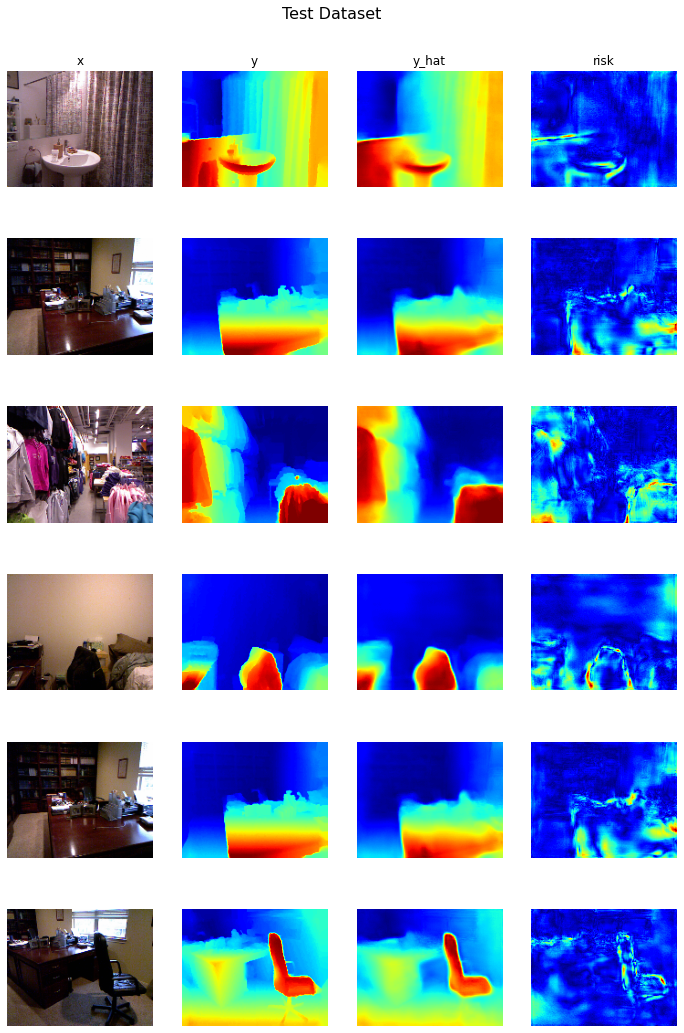

In [13]:
vis_depth_map(epistemic_model, ds_test)

With and epistemic method, we are able to capture uncertainty in model’s prediction itself. We see that increased epistemic uncertainty roughly corresponds to the semantically and visually challenging pixels where the model is making errors.

### To sum up 🏆
- With ``Capsa`` we converted our existing model to its risk aware variant with one line of code.
- We trained this model with the same steps as the initial (not wrapped) model.
- We saw different risk estimates in action, and explaind their semantic meaning!

In the next part of the tutorial (part 6) we'll use the risk estimates to solve an actual real world problem.